In [1]:
import sys
sys.path.append('../src/')

import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
x = np.random.random((100,2))
x = pd.DataFrame(x, columns=['x1', 'x2'])
def evaluate_objective(_x):
    _x = _x.values
    r1 = _x[:,0]
    r2 = _x[:,1]
    r3 = -(r1**2 + r2**2)
    r4 = -(r1+r2)
    r_all = np.array([r1, r2, r3, r4]).T
    r_all = pd.DataFrame(r_all, columns=['r1', 'r2', 'r3', 'r4'])
    return r_all
# def check_constraint(_x):
#     _x = _x.values
#     r1 = _x[:,[0]]
#     r2 = _x[:,[1]]
#     r3 = np.minimum(r1, r2)-0.5
#     return r3
y = evaluate_objective(x)
# c = check_constraint(x)
# valid_idx = c>=0
# x = x[valid_idx]
# y = y[valid_idx]

In [3]:
import random

from pymoo.core.variable import Real

data = data_package.DataPackage(features_dataset=x,
                           predictions_dataset=y,
                           query_x=x.iloc[0:1],
                           design_targets=design_targets.DesignTargets([design_targets.ContinuousTarget(label="r1", lower_bound=0.1,upper_bound=0.5),
                                                                        design_targets.ContinuousTarget(label="r2", lower_bound=-np.inf,upper_bound=0.5),
                                                                        design_targets.ContinuousTarget(label="r3", lower_bound=-1.0,upper_bound=np.inf),
                                                                        design_targets.ContinuousTarget(label="r4", lower_bound=-1.0,upper_bound=np.inf)]),
                           datatypes=[Real(bounds=(0, 1)), Real(bounds=(0, 1))])

problem = MOP.MultiObjectiveProblem(data_package=data,
                                prediction_function = evaluate_objective,
                                constraint_functions=[])

generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem,
                                     pop_size=100,
                                     initialize_from_dataset=False)

generator.generate(n_generations=100)
counterfactuals = generator.sample_with_dtai(num_samples=100, gower_weight=1,
                                             avg_gower_weight=1, cfc_weight=1,
                                             diversity_weight=50, include_dataset=False)
print(counterfactuals)

Initial population randomly initialized!

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       99 |      3 |  0.000000E+00 |  0.5314490470 |             - |             -
     2 |      199 |      4 |  0.000000E+00 |  0.1566682364 |  0.2296848068 |         ideal
     3 |      299 |      6 |  0.000000E+00 |  0.0444681816 |  0.0068507563 |             f
     4 |      399 |      5 |  0.000000E+00 |  0.0116410289 |  0.0342129581 |             f
     5 |      499 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1657254597 |         ideal
     6 |      599 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0468280587 |         ideal
     7 |      699 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0312667966 |

c:\Users\Lyle\mambaforge\envs\mcd\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lyle\mambaforge\envs\mcd\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lyle\mambaforge\envs\mcd\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lyle\mambaforge\envs\mcd\Lib\site-packages\seaborn\_oldcore.py:1075: Fut

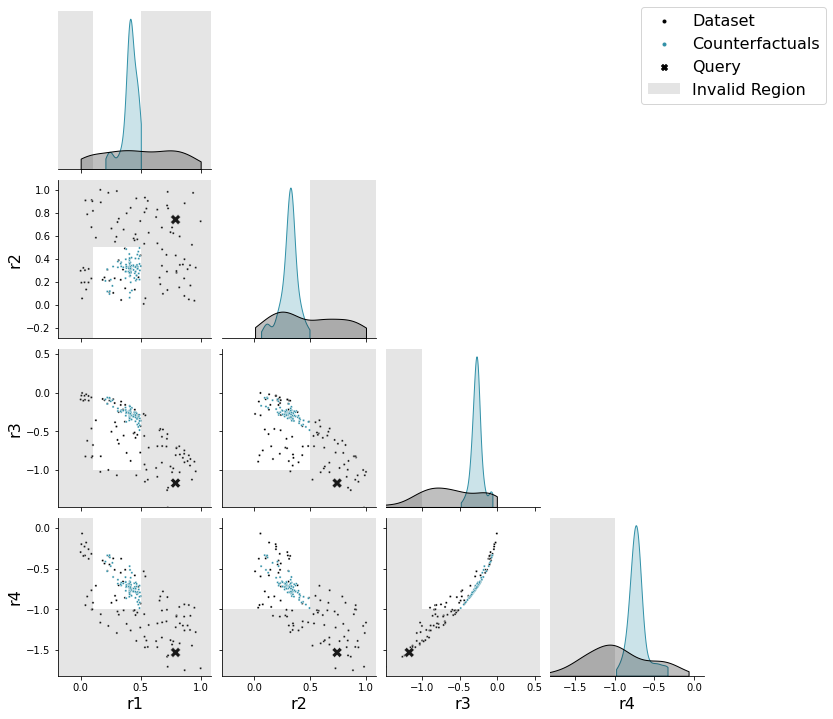

In [53]:
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.path import Path
from scipy.stats import zscore

def plot_cfs(counterfactuals, generator, corner=True, fontsize=16, include_dataset=True, outlier_thresh=3):
    query = generator._problem._data_package.query_x
    query.index = ['query']
    counterfactuals_and_query = pd.concat([query, counterfactuals], axis=0)
    obj_scores = generator._problem._get_predictions(counterfactuals_and_query, False)
    column_names = generator._problem._data_package.predictions_dataset.columns
    obj_scores = pd.DataFrame(obj_scores, columns=column_names)

    s = [100] + [20]*100 
    markers=["X", "."]
    palette=["#000000", "#3291a8",]
    classes = ["Query"] + ["Counterfactuals"]*len(counterfactuals) 

    #Add in Dataset
    if include_dataset:
        dataset = generator._problem._data_package.predictions_dataset
        obj_scores = pd.concat([obj_scores, dataset], axis=0)
        s = s+ [20]*100 
        markers = markers + ["."]
        # palette = palette + ["#eba834"]
        # palette = palette + ["#f24954"]
        palette = palette + ["#000000"]
        classes = classes + ["Dataset"]*len(dataset)


    
    

    scores = []
    minimums = []
    maximums = []
    plot_minimums = []
    plot_maximums = []
    for i, target in enumerate(generator._problem._data_package.design_targets.continuous_targets):
        name = target.label
        score = obj_scores[name]
        scores.append(score)
        minimums.append(target.lower_bound)
        maximums.append(target.upper_bound)
        if outlier_thresh:
            score = score.values
            query = score[0]
            mean = score.mean(axis=0)
            std = score.std(axis=0)
            plot_minimum = mean - outlier_thresh*std
            plot_maximum = mean + outlier_thresh*std
            plot_minimums.append(min(plot_minimum, query))
            plot_maximums.append(max(plot_maximum, query))
        else:
            plot_minimums.append(score.min(axis=0))
            plot_maximums.append(obj_scores.max(axis=0))

    scores = pd.concat(scores, axis=1)
    # print(scores)
    num = len(scores.columns)
    #add column to distinguish query
    
    scores['class'] = classes
    
    #invert order of points
    scores = scores.iloc[::-1]
    s = s[::-1]
    markers = markers[::-1]
    palette = palette[::-1]
    
    grid = sns.pairplot(scores, hue = "class", kind="scatter", diag_kind="kde", palette=palette, markers=markers, plot_kws={"s": s}, diag_kws={"cut":0}, corner=corner)


    #add shaded region to plot
    for i, ax in enumerate(grid.axes.ravel()):
        x_idx = i%num
        y_idx = i//num
        if corner:
            if x_idx > y_idx:
                continue

        minx_i = max(minimums[x_idx], plot_minimums[x_idx])
        maxx_i = min(maximums[x_idx], plot_maximums[x_idx])
        miny_i = max(minimums[y_idx], plot_minimums[y_idx])
        maxy_i = min(maximums[y_idx], plot_maximums[y_idx])
        minx_o = plot_minimums[x_idx]
        maxx_o = plot_maximums[x_idx]
        miny_o = plot_minimums[y_idx]
        maxy_o = plot_maximums[y_idx]

        #set axis limits
        ax.set_xlim(minx_o, maxx_o)
        ax.set_ylim(miny_o, maxy_o)
        

        if x_idx!=y_idx:            
            vertices = [
                (minx_o, miny_o),  # Botton left of outer rect
                (minx_o, maxy_o),  # Top left
                (maxx_o, maxy_o),  # Top right
                (maxx_o, miny_o),  # Bottom right
                (minx_o, miny_o),  # Bottom left again to close the path
                (minx_i, miny_i),  # Botton left of inner rect
                (maxx_i, miny_i),  # Bottom right
                (maxx_i, maxy_i),  # Top right
                (minx_i, maxy_i),  # Top left
                (minx_i, miny_i),  # Bottom left again to close the path
            ]

            codes = [
                Path.MOVETO,  # Start path
                Path.LINETO,  # Line to top-left of outer rectangle
                Path.LINETO,  # Line to top-right
                Path.LINETO,  # Line to bottom-right
                Path.CLOSEPOLY,  # Close the outer rectangle
                Path.MOVETO,  # Start path for the inner rectangle
                Path.LINETO,  # Line to bottom-right of inner rectangle
                Path.LINETO,  # Line to top-right
                Path.LINETO,  # Line to top-left
                Path.CLOSEPOLY,  # Close the inner rectangle (creates the cut-out effect)
            ]

            # Combine vertices and codes into a path object
            path = Path(vertices, codes)

            # Create a patch based on the path object
            patch = patches.PathPatch(path, facecolor='gray', lw=0, alpha=0.2)
            ax.add_patch(patch)
        else:
            rect = patches.Rectangle((maxx_i, miny_o),maxx_o-maxx_i,maxy_o-miny_o,linewidth=0,edgecolor='black',facecolor='gray', alpha=0.2)
            ax.add_patch(rect)
            rect = patches.Rectangle((minx_o, miny_o),minx_i-minx_o,maxy_o-miny_o,linewidth=0,edgecolor='black',facecolor='gray', alpha=0.2)
            ax.add_patch(rect)

        #set axis label sizes
        ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
        ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)

    #add shaded region to legend
    legend = grid.fig.legends[0]  # Get the first (and typically only) legend
    handles, labels = legend.legend_handles, [text.get_text() for text in legend.texts]
    handles.append(patch)
    labels.append('Invalid Region')

    # Remove the existing legend
    for legend in grid.fig.legends:
        legend.remove()
    #Create replacement
    grid.fig.legend(handles, labels, loc='upper right', title='', fontsize = fontsize, bbox_to_anchor=(1, 1))
    
        
    plt.show()
    
plot_cfs(counterfactuals, generator)